# Simulate workers at a call center processing calls

Current constraints:
1. One shift of workers
2. Every call takes the same amount of time
3. Workers do not take breaks
4. Callers never hang up

Free parameters:
1. Number of workers
2. How long each call takes

Goal:
- Determine which calls were processed successfully and which were missed

In [1]:
from queue import Queue
from queue import LifoQueue
from queue import PriorityQueue

from datetime import datetime
from datetime import date
from datetime import time
from datetime import timedelta

from tqdm import tqdm
import pandas as pd

from collections import defaultdict
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

## Read all individual call events

In [2]:
def read_calls(fname):
    calls = []
    with open(fname, "r") as fin:
        for line in fin:
            line = line.rstrip("\n")
            
            # use time.fromisoformat() in future (python 3.7+)
            hour, minute, second = map(int, line.split(":"))
            calls.append(time(hour=hour, minute=minute, second=second))
            
    return calls

### Generate call stack

In [3]:
def get_call_stack(call_list):
    call_stack = LifoQueue()
    for call in reversed(call_list):
        call_stack.put(call)
        
    return call_stack

## Perform simulation with the given constraints

In [4]:
def simulate(num_workers, call_length, call_stack):
    """Simulate a call center.
    
    Constraints:
        - one shift of workers
        - every call takes the same amount of time
        - workers do not take breaks
        - callers never hang up

    Arguments:
        - num_workers: how many call center workers
        - call_length: how long each call takes
        - call_stack: sorted stack of call times rounded to the nearest second

    Goal:
        Determine which calls were processed successfully and which were missed

    Returns:
        Number of successfully processed calls
    """

    assert num_workers >= 0
    assert isinstance(call_length, timedelta)
    assert isinstance(call_stack, LifoQueue)

    # constants

    TIME_RESOLUTION = timedelta(seconds=1)

    # when the workers start and stop working
    START_TIME = time(hour=5, minute=0)
    END_TIME = time(hour=22, minute=30)

    #--------------------------------------------------------------------------

    cur_time = datetime.combine(date.min, START_TIME)
    stop_time = datetime.combine(date.min, END_TIME)


    hold_line = Queue() # callers who are on hold because all agents are busy

    # agents who are not currently busy with callers
    free_workers = Queue()
    for i in range(num_workers):
        free_workers.put(i)

    # when workers finish processing calls and worker id
    work_line = PriorityQueue()

    
    num_successful_calls = 0

    while cur_time < stop_time:

        # add new callers to wait queue
        while not call_stack.empty():
            new_call = call_stack.get()

            new_call_datetime = datetime.combine(date.min, new_call)

            if cur_time == new_call_datetime:
                hold_line.put(new_call)
            else:
                assert cur_time < new_call_datetime

                call_stack.put(new_call)
                break


        # free up any workers who are done
        while not work_line.empty():
            earliest, worker_id = work_line.get()

            if cur_time < earliest:
                work_line.put((earliest, worker_id))
                break
            else:
                assert cur_time == earliest

                num_successful_calls += 1
                free_workers.put(worker_id)


        # assign free workers to new callers
        while not free_workers.empty() and not hold_line.empty():
            worker_id = free_workers.get()
            caller_time = hold_line.get()

            # check to see if caller should hang up in future
            finish_datetime = cur_time + call_length

            work_line.put((finish_datetime, worker_id))


        cur_time += TIME_RESOLUTION    

    return num_successful_calls

## Examine performance for different number of workers

In [5]:
# go until all done or some max number (to prevent infinite loops)

MAX_WORKERS = 50
MAX_TALK_TIME_MINUTES = 16

call_times_fname = "data/call_times_uniform.txt"
call_list = read_calls(call_times_fname)

TOTAL_CALLS = len(call_list)

res = defaultdict(list)

for talk_mins in tqdm(range(1, MAX_TALK_TIME_MINUTES)):

    call_length = timedelta(minutes=talk_mins)

    for num_workers in range(MAX_WORKERS):
        # need a new stack each time because it gets modified
        call_stack = get_call_stack(call_list)

        num_successful = simulate(num_workers, call_length, call_stack)

        res["num_workers"].append(num_workers)
        res["num_successful"].append(num_successful)
        res["call_length_mins"].append(talk_mins)

        if num_successful == TOTAL_CALLS:
            break

res = pd.DataFrame(res)

  0%|          | 0/15 [00:00<?, ?it/s]


---

## Simulation results

In [6]:
res.head()

,num_workers,num_successful,call_length_mins
0,0,0,1
1,1,1024,1
2,2,1993,1
3,3,2350,1
4,0,0,2


In [7]:
res.shape

(311, 3)

---

In [8]:
TOTAL_CALLS

2350

In [9]:
fres = res.assign(
    pct_success = lambda df: df["num_successful"].divide(TOTAL_CALLS).multiply(100)
)

In [10]:
fres.head()

,num_workers,num_successful,call_length_mins,pct_success
0,0,0,1,0.000000
1,1,1024,1,43.574468
2,2,1993,1,84.808511
3,3,2350,1,100.000000
4,0,0,2,0.000000


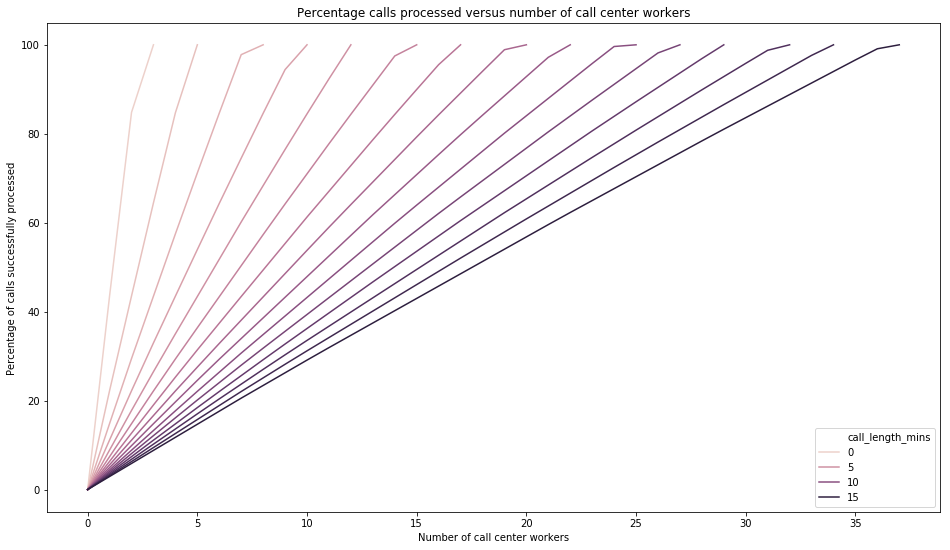

In [11]:
plt.figure(figsize=(16, 9), facecolor="white")

ax = sns.lineplot(
    data=fres, x="num_workers", y="pct_success",
    hue="call_length_mins"
)

ax.set_xlabel("Number of call center workers")
ax.set_ylabel("Percentage of calls successfully processed")

ax.set_title("Percentage calls processed versus number of call center workers");